In [1]:
import os
import numpy as np

from configuration.configuration import Configuration #class

from pandas.core.frame import DataFrame #class
from pandas.core.series import Series #class

from datasets.aDataset import ADataset #class
from datasets.datasetML import DatasetML #class

from datasets.ml.ratings import Ratings #class
from datasets.ml.items import Items #class
from datasets.ml.users import Users #class

from history.historyDF import HistoryDF #class

from recommender.aRecommender import ARecommender #class

import pandas as pd

from sklearn.model_selection import ParameterGrid

## Prepare train and test sets

In [2]:
TRAIN_RATIO = 0.8
VALIDATION_RATIO = 0.1
dataset:DatasetML = DatasetML.readDatasets()

ratingsDF:DataFrame = dataset.ratingsDF
usersDF:DataFrame = dataset.usersDF
itemsDF:DataFrame = dataset.itemsDF

ratingsSortedDF:DataFrame = ratingsDF.sort_values(by=Ratings.COL_TIMESTAMP)
numberOfRatings:int = ratingsSortedDF.shape[0]

trainSize:int = (int)(numberOfRatings * TRAIN_RATIO)
trainRatingsDF:DataFrame = ratingsSortedDF[0:trainSize]
trainRatingsDF = trainRatingsDF.loc[trainRatingsDF[Ratings.COL_RATING] >= 4] 
#trainRatingsDF.max()

testSize:int = (int)(numberOfRatings * VALIDATION_RATIO)    
testRatingsDF:DataFrame = ratingsSortedDF[trainSize:(trainSize + testSize)]
testRatingsDF = testRatingsDF.loc[testRatingsDF[Ratings.COL_RATING] >= 4] 


testRatingsDF.reset_index(drop=True, inplace=True)
trainRatingsDF.reset_index(drop=True, inplace=True)

trainDataset:ADataset = DatasetML(trainRatingsDF, usersDF, itemsDF)
trainRatingsDF.shape

(463020, 4)

In [3]:
testRatingsDF.shape

(57808, 4)

In [4]:
testRatingsDF.head()

,userId,movieId,rating,timestamp
0,1875,1721,4,975768738
1,1875,2621,4,975768748
2,635,3095,5,975768756
3,635,36,5,975768756
4,635,608,5,975768756


## Define recommending requests + some statistics on TRUE_vals sizes

In [5]:
users = testRatingsDF[Ratings.COL_USERID].unique()
users.shape

(1103,)

In [6]:
users

array([1875,  635, 2784, ...,   26,   25,   24], dtype=int64)

In [14]:
trueList = {}
trueRelevance = {}
vals = []
maxOID = itemsDF[Items.COL_MOVIEID].max()

for user in users:
    trueValsPerUser = testRatingsDF.loc[testRatingsDF[Ratings.COL_USERID] == user]
    trueValsPerUser = trueValsPerUser.iloc[0:5]#APPLY window for the current user
    vals.append(trueValsPerUser.shape[0])
    #print(trueValsPerUser.shape[0])
    trueList[user] = trueValsPerUser[Ratings.COL_MOVIEID]
    relScore = np.zeros((1,maxOID+1))
    relScore[0,trueList[user].values] = 1
    trueRelevance[user] = relScore

In [15]:
trueRelevance[1875].sum()

5.0

In [16]:
import numpy as np
np.sum(vals)

4877

In [17]:
np.max(vals),np.min(vals)

(5, 1)

In [18]:
pd.Series(vals).hist()

<AxesSubplot:>

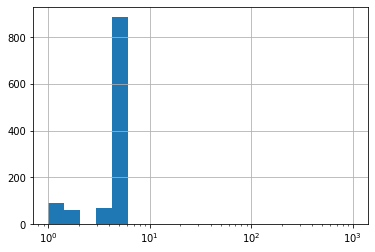

In [19]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
pd.Series(vals).hist(ax=ax, bins=np.logspace(np.log10(1),np.log10(1000), 20))
ax.set_xscale('log')

In [20]:
trueList[1875]

0    1721
1    2621
7      11
8     539
9    1722
Name: movieId, dtype: int64

In [21]:
trueList[1875].values

array([1721, 2621,   11,  539, 1722], dtype=int64)

## Run tuning for BPRMF

In [22]:
"""param_grid = {
              'factors': [5, 10, 20, 50, 100],
              'iterations': [5, 10, 20, 50], 
              'learning_rate': [0.1, 0.03, 0.01, 0.003],
              'regularization': [0.1, 0.03, 0.01, 0.003],
             }
""" 
param_grid = {
              'factors': [5, 10, 20, 50, 100],
              'iterations': [5, 10, 20, 50], 
              'learning_rate': [0.1, 0.03, 0.01, 0.003],
              'regularization': [0.1, 0.03, 0.01, 0.003],
             }
params_list = list(ParameterGrid(param_grid)) 

In [16]:
from recommender.recommenderBPRMF import RecommenderBPRMF #class
from sklearn.metrics import ndcg_score

ModuleNotFoundError: No module named 'implicit'

In [80]:
i = 0

scoresMean = []
scoresInd = []

for params in params_list:
    i += 1
    rec:ARecommender = RecommenderBPRMF("test", params)
    rec.train(HistoryDF("hyperparams_tuning_BPRMF"+str(i)), trainDataset)
    scoresVector = []
    
    for user in users:
        recList = rec.recommend(user)
        #print(recList.index)
        #print(type(recList.index))
        #rl = np.array([i[0] for i in recList])
        #print(rl)
        relScore = np.zeros((1,maxOID+1))
        relScore[0,recList.index] = recList.values
        #print(relScore.sum())
        #print(np.isin(recList.index, trueList[user].values))
        res = ndcg_score(trueRelevance[user], relScore, k=20)
        scoresVector.append(res)
        
    meanScore = np.mean(scoresVector)
    scoresMean.append(meanScore)
    scoresInd.append(scoresVector)    

par = [params_list[0]]

resultsDF = pd.DataFrame({"params":params_list, "meanNDCG":scoresMean})
resultsDF
        
    

,params,meanNDCG
0,"{'factors': 5, 'iterations': 5, 'learning_rate...",0.231033
1,"{'factors': 5, 'iterations': 5, 'learning_rate...",0.225477
2,"{'factors': 5, 'iterations': 5, 'learning_rate...",0.227545
3,"{'factors': 5, 'iterations': 5, 'learning_rate...",0.227705
4,"{'factors': 5, 'iterations': 5, 'learning_rate...",0.223632
...,...,...
315,"{'factors': 100, 'iterations': 50, 'learning_r...",0.222730
316,"{'factors': 100, 'iterations': 50, 'learning_r...",0.221546
317,"{'factors': 100, 'iterations': 50, 'learning_r...",0.223098
318,"{'factors': 100, 'iterations': 50, 'learning_r...",0.226047


In [96]:
resultsDF.to_csv("hp_results_BPRMF.csv")

In [81]:
resultsDF.sort_values(by="meanNDCG")

,params,meanNDCG
59,"{'factors': 5, 'iterations': 50, 'learning_rat...",0.210338
205,"{'factors': 50, 'iterations': 5, 'learning_rat...",0.211386
117,"{'factors': 10, 'iterations': 50, 'learning_ra...",0.214138
52,"{'factors': 5, 'iterations': 50, 'learning_rat...",0.215004
49,"{'factors': 5, 'iterations': 50, 'learning_rat...",0.215077
...,...,...
18,"{'factors': 5, 'iterations': 10, 'learning_rat...",0.236374
217,"{'factors': 50, 'iterations': 10, 'learning_ra...",0.236512
17,"{'factors': 5, 'iterations': 10, 'learning_rat...",0.237037
88,"{'factors': 10, 'iterations': 10, 'learning_ra...",0.237093


In [92]:
resultsDF.iloc[82,0] # BEST PARAMS for BPRMF {'factors': 10, 'iterations': 10, 'learning_rate': 0.1, 'regularization': 0.01}

{'factors': 10, 'iterations': 10, 'learning_rate': 0.1, 'regularization': 0.01}

In [ ]:
#TODO:  try default values for BPRMF


## Run tuning for CosineCB

In [23]:
param_grid = {
              'cbDataPath': [Configuration.cbDataFileWithPathTFIDF, Configuration.cbDataFileWithPathOHE],
              'userProfileStrategy': ["mean", "max",  "weightedMean"], 
              'userProfileSize': [-1, 1, 3, 5, 7, 10]
             }
params_list = list(ParameterGrid(param_grid))

In [24]:
params_list[0]

{'cbDataPath': '..\\data\\cbDataTFIDF.txt',
 'userProfileSize': -1,
 'userProfileStrategy': 'mean'}

In [25]:
from recommender.recommenderCosineCB import RecommenderCosineCB #class
from sklearn.metrics import ndcg_score

In [26]:
i = 0

scoresMean = []
scoresInd = []

for params in params_list:
    i += 1
    rec:ARecommender = RecommenderCosineCB("test", params)
    rec.train(HistoryDF("hyperparams_tuning_CosineCB"+str(i)), trainDataset)
    scoresVector = []
    
    for user in users:
        recList = rec.recommend(user, 20, params)
        #print(recList.index)
        #print(type(recList.index))
        #rl = np.array([i[0] for i in recList])
        #print(rl)
        relScore = np.zeros((1,maxOID+1))
        relScore[0,recList.index] = recList.values
        #print(relScore.sum())
        #print(np.isin(recList.index, trueList[user].values))
        res = ndcg_score(trueRelevance[user], relScore, k=20)
        scoresVector.append(res)
        
    meanScore = np.mean(scoresVector)
    scoresMean.append(meanScore)
    scoresInd.append(scoresVector)
    print(meanScore)

par = [params_list[0]]

resultsDF = pd.DataFrame({"params":params_list, "meanNDCG":scoresMean})
resultsDF

{'cbDataPath': '..\\data\\cbDataTFIDF.txt', 'userProfileSize': -1, 'userProfileStrategy': 'mean'}
0.0037881230988316174
{'cbDataPath': '..\\data\\cbDataTFIDF.txt', 'userProfileSize': -1, 'userProfileStrategy': 'max'}
0.0032272845002426992
{'cbDataPath': '..\\data\\cbDataTFIDF.txt', 'userProfileSize': -1, 'userProfileStrategy': 'weightedMean'}
0.003430735750185979
{'cbDataPath': '..\\data\\cbDataTFIDF.txt', 'userProfileSize': 1, 'userProfileStrategy': 'mean'}
0.004378676059123838
{'cbDataPath': '..\\data\\cbDataTFIDF.txt', 'userProfileSize': 1, 'userProfileStrategy': 'max'}
0.004378676059123838
{'cbDataPath': '..\\data\\cbDataTFIDF.txt', 'userProfileSize': 1, 'userProfileStrategy': 'weightedMean'}
0.004378676059123838
{'cbDataPath': '..\\data\\cbDataTFIDF.txt', 'userProfileSize': 3, 'userProfileStrategy': 'mean'}
0.0037276188610496116
{'cbDataPath': '..\\data\\cbDataTFIDF.txt', 'userProfileSize': 3, 'userProfileStrategy': 'max'}
0.0039279140871596036
{'cbDataPath': '..\\data\\cbDataTFID

,params,meanNDCG
0,"{'cbDataPath': '..\data\cbDataTFIDF.txt', 'use...",0.003788
1,"{'cbDataPath': '..\data\cbDataTFIDF.txt', 'use...",0.003227
2,"{'cbDataPath': '..\data\cbDataTFIDF.txt', 'use...",0.003431
3,"{'cbDataPath': '..\data\cbDataTFIDF.txt', 'use...",0.004379
4,"{'cbDataPath': '..\data\cbDataTFIDF.txt', 'use...",0.004379
5,"{'cbDataPath': '..\data\cbDataTFIDF.txt', 'use...",0.004379
6,"{'cbDataPath': '..\data\cbDataTFIDF.txt', 'use...",0.003728
7,"{'cbDataPath': '..\data\cbDataTFIDF.txt', 'use...",0.003928
8,"{'cbDataPath': '..\data\cbDataTFIDF.txt', 'use...",0.003625
9,"{'cbDataPath': '..\data\cbDataTFIDF.txt', 'use...",0.004808


In [27]:
resultsDF.sort_values(by="meanNDCG")

,params,meanNDCG
20,"{'cbDataPath': '..\data\cbDataOHE.txt', 'userP...",0.002923
35,"{'cbDataPath': '..\data\cbDataOHE.txt', 'userP...",0.003011
30,"{'cbDataPath': '..\data\cbDataOHE.txt', 'userP...",0.003123
1,"{'cbDataPath': '..\data\cbDataTFIDF.txt', 'use...",0.003227
17,"{'cbDataPath': '..\data\cbDataTFIDF.txt', 'use...",0.003289
32,"{'cbDataPath': '..\data\cbDataOHE.txt', 'userP...",0.003303
18,"{'cbDataPath': '..\data\cbDataOHE.txt', 'userP...",0.003310
33,"{'cbDataPath': '..\data\cbDataOHE.txt', 'userP...",0.003345
27,"{'cbDataPath': '..\data\cbDataOHE.txt', 'userP...",0.003414
29,"{'cbDataPath': '..\data\cbDataOHE.txt', 'userP...",0.003416


In [30]:
resultsDF.iloc[25,0] #best... however all are not so good compared to the MF

{'cbDataPath': '..\\data\\cbDataOHE.txt',
 'userProfileSize': 3,
 'userProfileStrategy': 'max'}

In [31]:
resultsDF.iloc[9,0] #secondBest

{'cbDataPath': '..\\data\\cbDataTFIDF.txt',
 'userProfileSize': 5,
 'userProfileStrategy': 'mean'}

In [32]:
resultsDF.iloc[21,0] #thirdBest

{'cbDataPath': '..\\data\\cbDataOHE.txt',
 'userProfileSize': 1,
 'userProfileStrategy': 'mean'}

## Test MostPopular - just to have an idea of how the baselines looks like

In [28]:
from recommender.recommenderTheMostPopular import RecommenderTheMostPopular #class
from sklearn.metrics import ndcg_score

In [29]:
rec:ARecommender = RecommenderTheMostPopular("test", {})
rec.train(HistoryDF("hyperparams_tuning_MP"+str(i)), trainDataset)
scoresVector = []
    
for user in users:
        recList = rec.recommend(user, 20, params)
        #print(recList.index)
        #print(type(recList.index))
        #rl = np.array([i[0] for i in recList])
        #print(rl)
        relScore = np.zeros((1,maxOID+1))
        relScore[0,recList.index] = recList.values
        #print(relScore.sum())
        #print(np.isin(recList.index, trueList[user].values))
        res = ndcg_score(trueRelevance[user], relScore, k=20)
        scoresVector.append(res)
        
meanScore = np.mean(scoresVector)
meanScore

0.10645535705452938

## Run tuning for Word2Vec

In [33]:
param_grid_userProfile = {
              'datasetId':["ml1m" + "Div" + str(80)],
              'trainVariant': ["positive"], 
              'iterations': [50000, 100000, 200000],
              'windowSize': [5, 3, 1],
              'vectorSize': [32, 64, 128],    
              'userProfileStrategy': ["mean", "max",  "weightedMean"], 
              'userProfileSize': [-1, 1, 3, 5, 7, 10]
             }
params_list_userProfile = list(ParameterGrid(param_grid_userProfile))

param_grid = {    
              'datasetId':["ml1m" + "Div" + str(80)],
              'trainVariant': ["positive"], 
              'iterations': [200000],
              'windowSize': [5, 3, 1],
              'vectorSize': [32, 64, 128]
             }
params_list = list(ParameterGrid(param_grid))

In [34]:
from recommender.recommenderW2V import RecommenderW2V #class
from sklearn.metrics import ndcg_score

In [18]:
i = 0
for params in params_list:
    i += 1
    rec:ARecommender = RecommenderW2V("test", params)
    rec.train(HistoryDF("hyperparams_tuning_CosineCB"+str(i)), trainDataset)



..\models\model_ml1mDiv80_positive_32_5_200000.pkl
..\models\dictionary_ml1mDiv80_positive_32_5_200000.pkl
..\models\rev_dict_ml1mDiv80_positive_32_5_200000.pkl
Creating Dictionary
Actual vocabulary size:3470
Loss at step 10000 : 2.912088632583618
Loss at step 20000 : 3.0665416717529297
Loss at step 30000 : 3.958158254623413
Loss at step 40000 : 1.8041181564331055
Loss at step 50000 : 1.8469690084457397
Nearest to 2858: 1961, 1503, 1663, 283, 3101,
Nearest to 608: 110, 1617, 3394, 1090, 691,
Nearest to 1206: 3471, 2600, 750, 541, 2331,
Nearest to 1135: 1440, 280, 1412, 1926, 2418,
Loss at step 60000 : 3.2472915649414062
Loss at step 70000 : 3.284290313720703
Loss at step 80000 : 2.7698185443878174
Loss at step 90000 : 1.574096441268921
Loss at step 100000 : 1.862308144569397
Nearest to 2858: 3450, 1259, 2668, 1569, 187,
Nearest to 608: 1090, 3060, 3394, 1388, 1899,
Nearest to 1206: 1214, 2600, 3703, 2, 25,
Nearest to 1135: 1440, 1412, 2122, 1429, 1027,
Loss at step 110000 : 2.848890304

In [35]:
i = 0

scoresMean = []
scoresInd = []

for params in params_list_userProfile:
    i += 1
    rec:ARecommender = RecommenderW2V("test", params)
    rec.train(HistoryDF("hyperparams_tuning_W2V"+str(i)), trainDataset)
    scoresVector = []
    
    for user in users:
        recList = rec.recommend(user, 20, params)
        #print(recList.index)
        #print(type(recList.index))
        #rl = np.array([i[0] for i in recList])
        #print(rl)
        relScore = np.zeros((1,maxOID+1))
        relScore[0,recList.index] = recList.values
        #print(relScore.sum())
        #print(np.isin(recList.index, trueList[user].values))
        res = ndcg_score(trueRelevance[user], relScore, k=20)
        scoresVector.append(res)
        
    meanScore = np.mean(scoresVector)
    scoresMean.append(meanScore)
    scoresInd.append(scoresVector)
    print(meanScore)

par = [params_list[0]]

resultsDF = pd.DataFrame({"params":params_list_userProfile, "meanNDCG":scoresMean})
resultsDF

..\models\model_ml1mDiv80_positive_32_5_50000.pkl
..\models\dictionary_ml1mDiv80_positive_32_5_50000.pkl
..\models\rev_dict_ml1mDiv80_positive_32_5_50000.pkl
0.006027130731025541
..\models\model_ml1mDiv80_positive_32_3_50000.pkl
..\models\dictionary_ml1mDiv80_positive_32_3_50000.pkl
..\models\rev_dict_ml1mDiv80_positive_32_3_50000.pkl
0.009431683750457156
..\models\model_ml1mDiv80_positive_32_1_50000.pkl
..\models\dictionary_ml1mDiv80_positive_32_1_50000.pkl
..\models\rev_dict_ml1mDiv80_positive_32_1_50000.pkl
0.006434633136391467
..\models\model_ml1mDiv80_positive_64_5_50000.pkl
..\models\dictionary_ml1mDiv80_positive_64_5_50000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_5_50000.pkl
0.008622334419894791
..\models\model_ml1mDiv80_positive_64_3_50000.pkl
..\models\dictionary_ml1mDiv80_positive_64_3_50000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_3_50000.pkl
0.011245030766700257
..\models\model_ml1mDiv80_positive_64_1_50000.pkl
..\models\dictionary_ml1mDiv80_positive_64_1_50000.pkl


0.006427581568601588
..\models\model_ml1mDiv80_positive_32_3_50000.pkl
..\models\dictionary_ml1mDiv80_positive_32_3_50000.pkl
..\models\rev_dict_ml1mDiv80_positive_32_3_50000.pkl
0.007306622588101132
..\models\model_ml1mDiv80_positive_32_1_50000.pkl
..\models\dictionary_ml1mDiv80_positive_32_1_50000.pkl
..\models\rev_dict_ml1mDiv80_positive_32_1_50000.pkl
0.004889076258437859
..\models\model_ml1mDiv80_positive_64_5_50000.pkl
..\models\dictionary_ml1mDiv80_positive_64_5_50000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_5_50000.pkl
0.005896078515251297
..\models\model_ml1mDiv80_positive_64_3_50000.pkl
..\models\dictionary_ml1mDiv80_positive_64_3_50000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_3_50000.pkl
0.007589233015567731
..\models\model_ml1mDiv80_positive_64_1_50000.pkl
..\models\dictionary_ml1mDiv80_positive_64_1_50000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_1_50000.pkl
0.006948369237604493
..\models\model_ml1mDiv80_positive_128_5_50000.pkl
..\models\dictionary_ml1mDiv80_po

0.006230633189407186
..\models\model_ml1mDiv80_positive_32_1_50000.pkl
..\models\dictionary_ml1mDiv80_positive_32_1_50000.pkl
..\models\rev_dict_ml1mDiv80_positive_32_1_50000.pkl
0.005270487316527311
..\models\model_ml1mDiv80_positive_64_5_50000.pkl
..\models\dictionary_ml1mDiv80_positive_64_5_50000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_5_50000.pkl
0.0059288650529522305
..\models\model_ml1mDiv80_positive_64_3_50000.pkl
..\models\dictionary_ml1mDiv80_positive_64_3_50000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_3_50000.pkl
0.007306980422770405
..\models\model_ml1mDiv80_positive_64_1_50000.pkl
..\models\dictionary_ml1mDiv80_positive_64_1_50000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_1_50000.pkl
0.006309809575955624
..\models\model_ml1mDiv80_positive_128_5_50000.pkl
..\models\dictionary_ml1mDiv80_positive_128_5_50000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_5_50000.pkl
0.006555944256892301
..\models\model_ml1mDiv80_positive_128_3_50000.pkl
..\models\dictionary_ml1mDiv8

0.00682729316623637
..\models\model_ml1mDiv80_positive_64_5_50000.pkl
..\models\dictionary_ml1mDiv80_positive_64_5_50000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_5_50000.pkl
0.008978167381798255
..\models\model_ml1mDiv80_positive_64_3_50000.pkl
..\models\dictionary_ml1mDiv80_positive_64_3_50000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_3_50000.pkl
0.008873042733425455
..\models\model_ml1mDiv80_positive_64_1_50000.pkl
..\models\dictionary_ml1mDiv80_positive_64_1_50000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_1_50000.pkl
0.01028079066819851
..\models\model_ml1mDiv80_positive_128_5_50000.pkl
..\models\dictionary_ml1mDiv80_positive_128_5_50000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_5_50000.pkl
0.009717818411868289
..\models\model_ml1mDiv80_positive_128_3_50000.pkl
..\models\dictionary_ml1mDiv80_positive_128_3_50000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_3_50000.pkl
0.011401177607104025
..\models\model_ml1mDiv80_positive_128_1_50000.pkl
..\models\dictionary_ml1mDiv8

0.00963962520130323
..\models\model_ml1mDiv80_positive_64_3_100000.pkl
..\models\dictionary_ml1mDiv80_positive_64_3_100000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_3_100000.pkl
0.008977142454322727
..\models\model_ml1mDiv80_positive_64_1_100000.pkl
..\models\dictionary_ml1mDiv80_positive_64_1_100000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_1_100000.pkl
0.007351730213084997
..\models\model_ml1mDiv80_positive_128_5_100000.pkl
..\models\dictionary_ml1mDiv80_positive_128_5_100000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_5_100000.pkl
0.009234096429088644
..\models\model_ml1mDiv80_positive_128_3_100000.pkl
..\models\dictionary_ml1mDiv80_positive_128_3_100000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_3_100000.pkl
0.012236471529557395
..\models\model_ml1mDiv80_positive_128_1_100000.pkl
..\models\dictionary_ml1mDiv80_positive_128_1_100000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_1_100000.pkl
0.0065322258187391485
..\models\model_ml1mDiv80_positive_32_5_100000.pkl
..\models

0.005898310911836937
..\models\model_ml1mDiv80_positive_64_3_100000.pkl
..\models\dictionary_ml1mDiv80_positive_64_3_100000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_3_100000.pkl
0.004270071379504373
..\models\model_ml1mDiv80_positive_64_1_100000.pkl
..\models\dictionary_ml1mDiv80_positive_64_1_100000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_1_100000.pkl
0.0038227974775693766
..\models\model_ml1mDiv80_positive_128_5_100000.pkl
..\models\dictionary_ml1mDiv80_positive_128_5_100000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_5_100000.pkl
0.004240134524106761
..\models\model_ml1mDiv80_positive_128_3_100000.pkl
..\models\dictionary_ml1mDiv80_positive_128_3_100000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_3_100000.pkl
0.005778073559532616
..\models\model_ml1mDiv80_positive_128_1_100000.pkl
..\models\dictionary_ml1mDiv80_positive_128_1_100000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_1_100000.pkl
0.005535447830428695
..\models\model_ml1mDiv80_positive_32_5_100000.pkl
..\model

0.008165767642698525
..\models\model_ml1mDiv80_positive_64_3_100000.pkl
..\models\dictionary_ml1mDiv80_positive_64_3_100000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_3_100000.pkl
0.005997709955581805
..\models\model_ml1mDiv80_positive_64_1_100000.pkl
..\models\dictionary_ml1mDiv80_positive_64_1_100000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_1_100000.pkl
0.006169241818670213
..\models\model_ml1mDiv80_positive_128_5_100000.pkl
..\models\dictionary_ml1mDiv80_positive_128_5_100000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_5_100000.pkl
0.0057137133125735
..\models\model_ml1mDiv80_positive_128_3_100000.pkl
..\models\dictionary_ml1mDiv80_positive_128_3_100000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_3_100000.pkl
0.005245931985291331
..\models\model_ml1mDiv80_positive_128_1_100000.pkl
..\models\dictionary_ml1mDiv80_positive_128_1_100000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_1_100000.pkl
0.005186017417123114
..\models\model_ml1mDiv80_positive_32_5_100000.pkl
..\models\d

0.00853720822554314
..\models\model_ml1mDiv80_positive_64_3_100000.pkl
..\models\dictionary_ml1mDiv80_positive_64_3_100000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_3_100000.pkl
0.0064105202922263545
..\models\model_ml1mDiv80_positive_64_1_100000.pkl
..\models\dictionary_ml1mDiv80_positive_64_1_100000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_1_100000.pkl
0.005841772945627414
..\models\model_ml1mDiv80_positive_128_5_100000.pkl
..\models\dictionary_ml1mDiv80_positive_128_5_100000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_5_100000.pkl
0.0064530359682808455
..\models\model_ml1mDiv80_positive_128_3_100000.pkl
..\models\dictionary_ml1mDiv80_positive_128_3_100000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_3_100000.pkl
0.006116079854453208
..\models\model_ml1mDiv80_positive_128_1_100000.pkl
..\models\dictionary_ml1mDiv80_positive_128_1_100000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_1_100000.pkl
0.006382862974560281
..\models\model_ml1mDiv80_positive_32_5_200000.pkl
..\model

0.005017058379569627
..\models\model_ml1mDiv80_positive_64_3_200000.pkl
..\models\dictionary_ml1mDiv80_positive_64_3_200000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_3_200000.pkl
0.00492602818896854
..\models\model_ml1mDiv80_positive_64_1_200000.pkl
..\models\dictionary_ml1mDiv80_positive_64_1_200000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_1_200000.pkl
0.005681942580306551
..\models\model_ml1mDiv80_positive_128_5_200000.pkl
..\models\dictionary_ml1mDiv80_positive_128_5_200000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_5_200000.pkl
0.004916686381185414
..\models\model_ml1mDiv80_positive_128_3_200000.pkl
..\models\dictionary_ml1mDiv80_positive_128_3_200000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_3_200000.pkl
0.004995499402240365
..\models\model_ml1mDiv80_positive_128_1_200000.pkl
..\models\dictionary_ml1mDiv80_positive_128_1_200000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_1_200000.pkl
0.004747045006746349
..\models\model_ml1mDiv80_positive_32_5_200000.pkl
..\models\

0.004501063543235729
..\models\model_ml1mDiv80_positive_64_3_200000.pkl
..\models\dictionary_ml1mDiv80_positive_64_3_200000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_3_200000.pkl
0.004764018034358778
..\models\model_ml1mDiv80_positive_64_1_200000.pkl
..\models\dictionary_ml1mDiv80_positive_64_1_200000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_1_200000.pkl
0.003882249886936853
..\models\model_ml1mDiv80_positive_128_5_200000.pkl
..\models\dictionary_ml1mDiv80_positive_128_5_200000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_5_200000.pkl
0.0039541095730304884
..\models\model_ml1mDiv80_positive_128_3_200000.pkl
..\models\dictionary_ml1mDiv80_positive_128_3_200000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_3_200000.pkl
0.004956879196339325
..\models\model_ml1mDiv80_positive_128_1_200000.pkl
..\models\dictionary_ml1mDiv80_positive_128_1_200000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_1_200000.pkl
0.005037617683411976
..\models\model_ml1mDiv80_positive_32_5_200000.pkl
..\model

0.00488073829729415
..\models\model_ml1mDiv80_positive_64_3_200000.pkl
..\models\dictionary_ml1mDiv80_positive_64_3_200000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_3_200000.pkl
0.005424682788272634
..\models\model_ml1mDiv80_positive_64_1_200000.pkl
..\models\dictionary_ml1mDiv80_positive_64_1_200000.pkl
..\models\rev_dict_ml1mDiv80_positive_64_1_200000.pkl
0.004022675703299457
..\models\model_ml1mDiv80_positive_128_5_200000.pkl
..\models\dictionary_ml1mDiv80_positive_128_5_200000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_5_200000.pkl
0.00417613661482078
..\models\model_ml1mDiv80_positive_128_3_200000.pkl
..\models\dictionary_ml1mDiv80_positive_128_3_200000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_3_200000.pkl
0.004957811363000856
..\models\model_ml1mDiv80_positive_128_1_200000.pkl
..\models\dictionary_ml1mDiv80_positive_128_1_200000.pkl
..\models\rev_dict_ml1mDiv80_positive_128_1_200000.pkl
0.005173766312434301
..\models\model_ml1mDiv80_positive_32_5_200000.pkl
..\models\d

,params,meanNDCG
0,"{'datasetId': 'ml1mDiv80', 'iterations': 50000...",0.006027
1,"{'datasetId': 'ml1mDiv80', 'iterations': 50000...",0.009432
2,"{'datasetId': 'ml1mDiv80', 'iterations': 50000...",0.006435
3,"{'datasetId': 'ml1mDiv80', 'iterations': 50000...",0.008622
4,"{'datasetId': 'ml1mDiv80', 'iterations': 50000...",0.011245
...,...,...
481,"{'datasetId': 'ml1mDiv80', 'iterations': 20000...",0.006380
482,"{'datasetId': 'ml1mDiv80', 'iterations': 20000...",0.003859
483,"{'datasetId': 'ml1mDiv80', 'iterations': 20000...",0.004292
484,"{'datasetId': 'ml1mDiv80', 'iterations': 20000...",0.005692


In [23]:
resultsDF = pd.DataFrame({"params":params_list_userProfile, "meanNDCG":scoresMean})
resultsDF

,params,meanNDCG
0,"{'datasetId': 'ml1mDiv80', 'iterations': 50000...",0.020524
1,"{'datasetId': 'ml1mDiv80', 'iterations': 50000...",0.025751
2,"{'datasetId': 'ml1mDiv80', 'iterations': 50000...",0.022062
3,"{'datasetId': 'ml1mDiv80', 'iterations': 50000...",0.025633
4,"{'datasetId': 'ml1mDiv80', 'iterations': 50000...",0.029389
...,...,...
481,"{'datasetId': 'ml1mDiv80', 'iterations': 20000...",0.018107
482,"{'datasetId': 'ml1mDiv80', 'iterations': 20000...",0.015431
483,"{'datasetId': 'ml1mDiv80', 'iterations': 20000...",0.015009
484,"{'datasetId': 'ml1mDiv80', 'iterations': 20000...",0.016897


In [36]:
resultsDF.sort_values(by="meanNDCG")[-10:]

,params,meanNDCG
109,"{'datasetId': 'ml1mDiv80', 'iterations': 50000...",0.011035
328,"{'datasetId': 'ml1mDiv80', 'iterations': 20000...",0.011176
4,"{'datasetId': 'ml1mDiv80', 'iterations': 50000...",0.011245
142,"{'datasetId': 'ml1mDiv80', 'iterations': 50000...",0.011401
187,"{'datasetId': 'ml1mDiv80', 'iterations': 10000...",0.012236
169,"{'datasetId': 'ml1mDiv80', 'iterations': 10000...",0.012733
7,"{'datasetId': 'ml1mDiv80', 'iterations': 50000...",0.013268
25,"{'datasetId': 'ml1mDiv80', 'iterations': 50000...",0.013332
6,"{'datasetId': 'ml1mDiv80', 'iterations': 50000...",0.013397
24,"{'datasetId': 'ml1mDiv80', 'iterations': 50000...",0.013450


In [37]:
resultsDF.iloc[24,0] #best... however all are not so good compared to the MF

{'datasetId': 'ml1mDiv80',
 'iterations': 50000,
 'trainVariant': 'positive',
 'userProfileSize': -1,
 'userProfileStrategy': 'weightedMean',
 'vectorSize': 128,
 'windowSize': 5}

In [38]:
resultsDF.iloc[6,0] #2nd best... however all are not so good compared to the MF

{'datasetId': 'ml1mDiv80',
 'iterations': 50000,
 'trainVariant': 'positive',
 'userProfileSize': -1,
 'userProfileStrategy': 'mean',
 'vectorSize': 128,
 'windowSize': 5}

In [39]:
resultsDF.iloc[25,0] #3rd best... however all are not so good compared to the MF

{'datasetId': 'ml1mDiv80',
 'iterations': 50000,
 'trainVariant': 'positive',
 'userProfileSize': -1,
 'userProfileStrategy': 'weightedMean',
 'vectorSize': 128,
 'windowSize': 3}

In [40]:
resultsDF.iloc[169,0] #4th best... however all are not so good compared to the MF

{'datasetId': 'ml1mDiv80',
 'iterations': 100000,
 'trainVariant': 'positive',
 'userProfileSize': -1,
 'userProfileStrategy': 'mean',
 'vectorSize': 128,
 'windowSize': 3}

In [37]:
resultsDF.iloc[400]

params      {'datasetId': 'ml1mDiv80', 'iterations': 20000...
meanNDCG                                            0.0156315
Name: 400, dtype: object